In [ ]:
import cartopy
import multiprocessing

import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from rasterio.warp import transform

In [58]:
# da = xr.open_rasterio('https://noaa-nbm-pds.s3.amazonaws.com/blendv4.0/conus/' +
#                       '2020/10/08/1200/probqpf24gt001/blendv4.0_conus_probqpf24gt001' + 
#                       '_2020-10-08T12%3A00_2020-10-09T12%3A00.tif',
#                      ).isel(band=0, x=slice(xi[0], xi[1]), y=slice(yi[0], yi[1])).drop('band')

In [88]:
xi, yi = [204, 1097], [219, 1269]

interval = 24

flist = []
for yyyy in [2020]:
    for mm in [10]:
        for dd in np.arange(1, 8):
            for hh in np.arange(0, 24, 6):

                init = datetime(yyyy, mm, dd, hh)
                
                for fhr in np.arange(interval, 180+1, 6):
                    
                    valid = init + timedelta(hours=int(fhr))
                
                    flist.append([init, valid, fhr, ('%04d/%02d/%02d/%02d00/'%(init.year, init.month, init.day, init.hour) +
                                  'probqpf%02dgt001/blendv4.0_conus_probqpf%02dgt001'%(interval, interval) +
                                  '_%04d-%02d-%02dT%02d%%3A00'%(init.year, init.month, init.day, init.hour) + 
                                  '_%04d-%02d-%02dT%02d%%3A00.tif'%(
                                      valid.year, valid.month, valid.day, valid.hour))])
q
def get_cog(f):
    url = 'https://noaa-nbm-pds.s3.amazonaws.com/blendv4.0/conus/' + f[3]    
    
    try:
        ds = xr.open_rasterio(url).isel(band=0, x=slice(xi[0], xi[1]), y=slice(yi[0], yi[1])).drop('band')
    except:
        return None
    else:
        ds['init'] = f[0]
        ds['valid'] = f[1]
        ds['fhr'] = f[2]
        return ds
                    
with multiprocessing.Pool(32) as p:
    
    data = p.map(get_cog, flist)
    p.close()
    p.join()
    
data

[<xarray.DataArray (y: 1050, x: 893)>
 [937650 values with dtype=int16]
 Coordinates:
   * y        (y) float64 3.233e+06 3.231e+06 3.228e+06 ... 5.718e+05 5.692e+05
   * x        (x) float64 -2.753e+06 -2.751e+06 ... -4.902e+05 -4.876e+05
     init     datetime64[ns] 2020-10-01
     valid    datetime64[ns] 2020-10-02
     fhr      int64 24
 Attributes:
     transform:      (2539.703, 0.0, -3272421.457337171, 0.0, -2539.703, 37908...
     crs:            +proj=lcc +lat_0=25 +lon_0=265 +lat_1=25 +lat_2=25 +x_0=0...
     res:            (2539.703, 2539.703)
     is_tiled:       1
     nodatavals:     (nan,)
     scales:         (1.0,)
     offsets:        (0.0,)
     descriptions:   ('0[-] SFC="Ground or water surface"',)
     AREA_OR_POINT:  Area,
 <xarray.DataArray (y: 1050, x: 893)>
 [937650 values with dtype=int16]
 Coordinates:
   * y        (y) float64 3.233e+06 3.231e+06 3.228e+06 ... 5.718e+05 5.692e+05
   * x        (x) float64 -2.753e+06 -2.751e+06 ... -4.902e+05 -4.876e+05
   

In [ ]:
data = [d for d in data if d is not None]
data = xr.concat(data, dim='init')
data

In [48]:
# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])

# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

da

<xarray.DataArray (time: 28, y: 1050, x: 893)>
array([[[68, 68, 68, ..., 36, 35, 35],
        [68, 68, 68, ..., 36, 35, 35],
        [68, 68, 67, ..., 37, 35, 34],
        ...,
        [ 6,  6,  6, ...,  2,  2,  2],
        [ 6,  6,  6, ...,  2,  2,  2],
        [ 6,  6,  6, ...,  2,  2,  2]],

       [[55, 55, 55, ..., 52, 52, 52],
        [55, 55, 55, ..., 52, 52, 51],
        [54, 54, 54, ..., 53, 51, 50],
        ...,
        [ 5,  5,  5, ...,  3,  3,  3],
        [ 5,  5,  5, ...,  3,  3,  3],
        [ 5,  5,  5, ...,  3,  3,  3]],

       [[58, 57, 57, ..., 47, 47, 47],
        [57, 57, 57, ..., 48, 47, 47],
        [57, 57, 57, ..., 48, 47, 46],
        ...,
...
        ...,
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  2,  2]],

       [[80, 80, 80, ..., 69, 68, 66],
        [80, 80, 80, ..., 72, 69, 66],
        [80, 80, 80, ..., 74, 70, 67],
        ...,
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1]],

       [[80, 80, 80, ..., 70, 68, 66],
        [80, 80, 80, ..., 72, 69, 67],
        [81, 81, 81, ..., 74, 71, 68],
        ...,
        [ 1,  1,  1, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  0,  0,  0]]], dtype=int16)
Coordinates:
  * y        (y) float64 3.233e+06 3.231e+06 3.228e+06 ... 5.718e+05 5.692e+05
  * x        (x) float64 -2.753e+06 -2.751e+06 ... -4.902e+05 -4.876e+05
  * time     (time) datetime64[ns] 2020-10-01 ... 2020-10-07T18:00:00
    lon      (y, x) float64 -130.0 -130.0 -129.9 -129.9 ... -100.1 -100.1 -100.0
    lat      (y, x) float64 49.98 49.99 49.99 50.0 ... 30.03 30.03 30.03 30.03
Attributes:
    transform:      (2539.703, 0.0, -3272421.457337171, 0.0, -2539.703, 37908...
    crs:            +proj=lcc +lat_0=25 +lon_0=265 +lat_1=25 +lat_2=25 +x_0=0...
    res:            (2539.703, 2539.703)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('0[-] SFC="Ground or water surface"',)
    AREA_OR_POINT:  Area

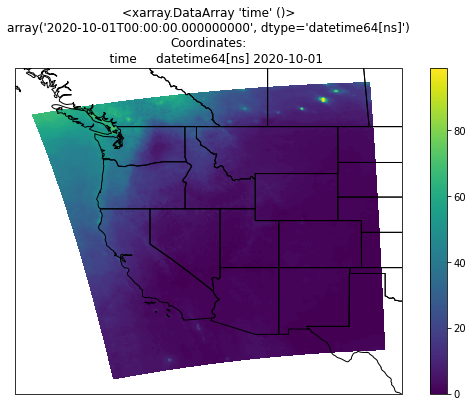

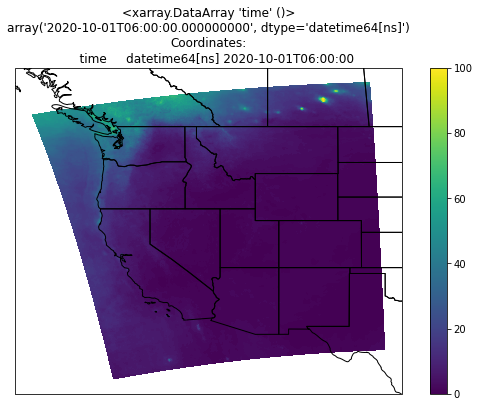

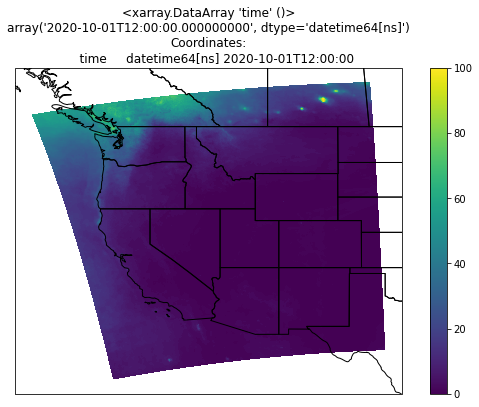

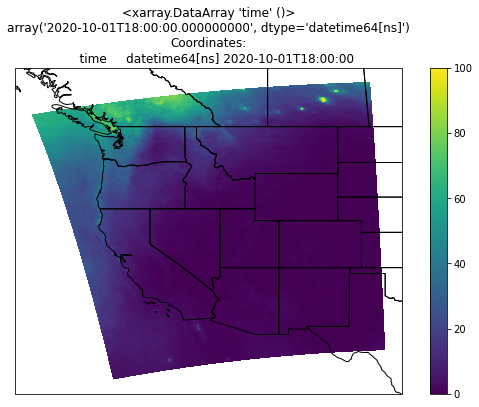

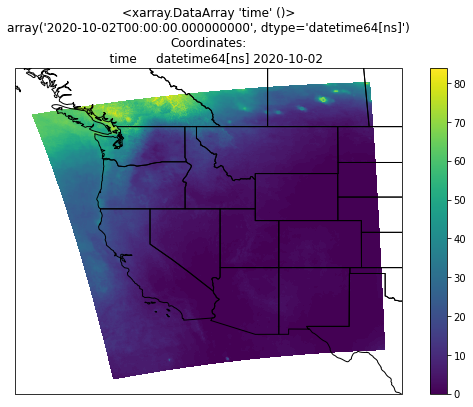

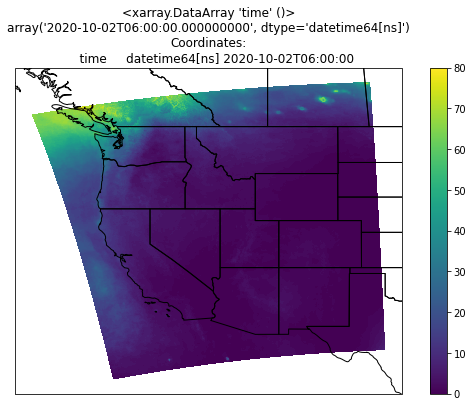

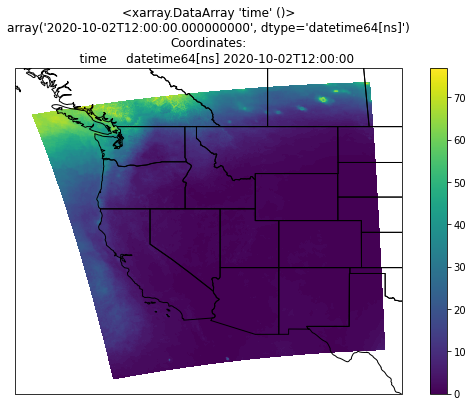

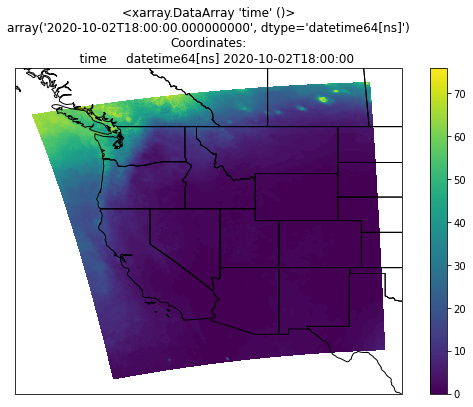

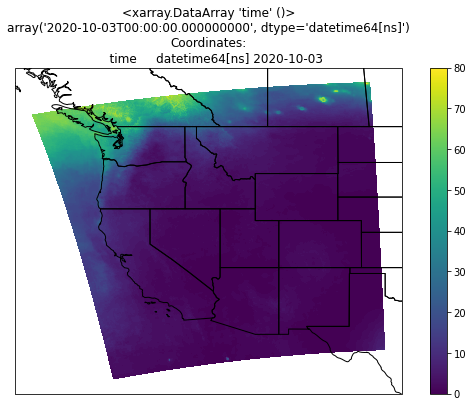

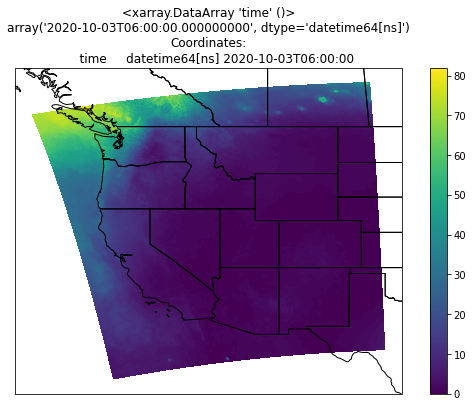

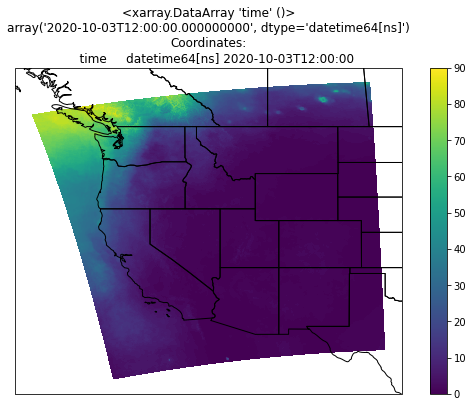

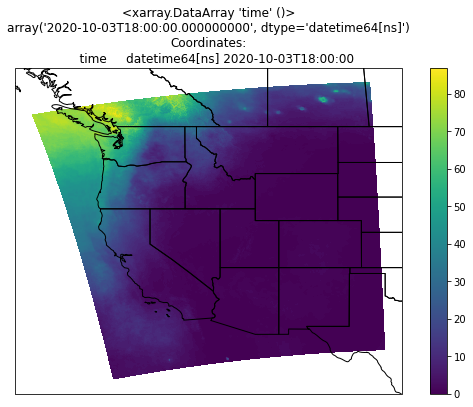

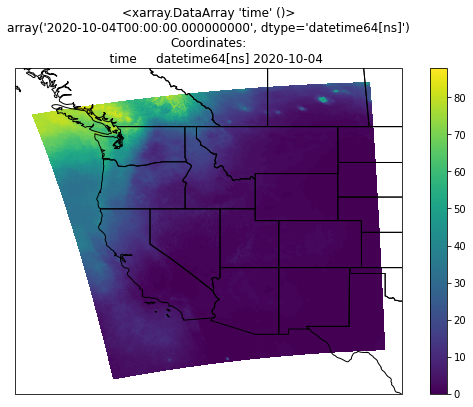

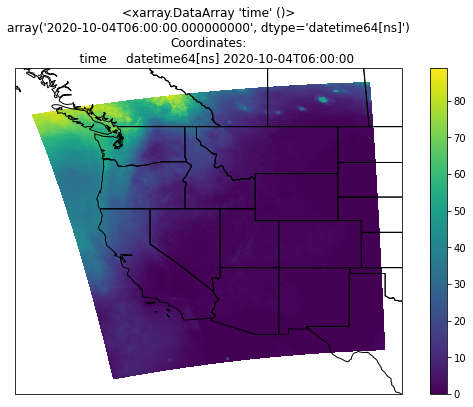

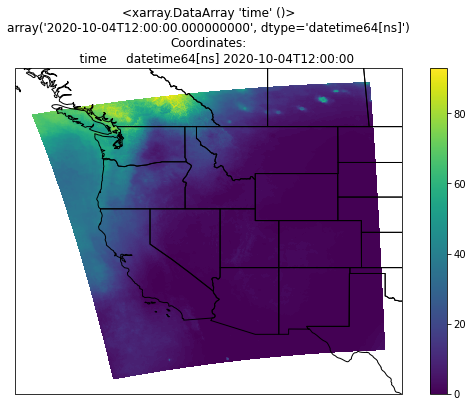

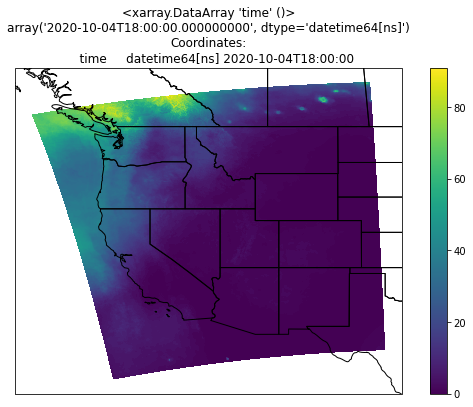

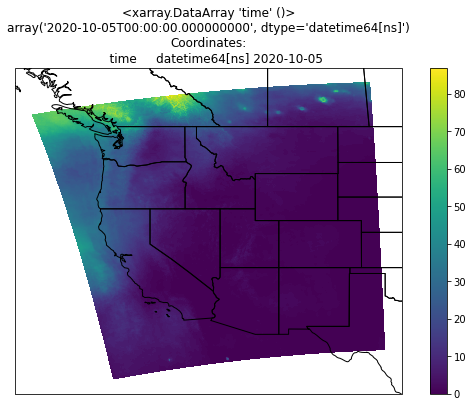

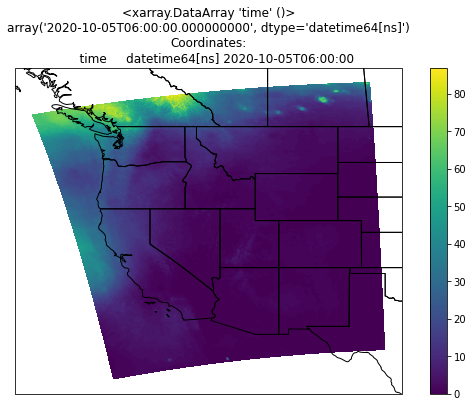

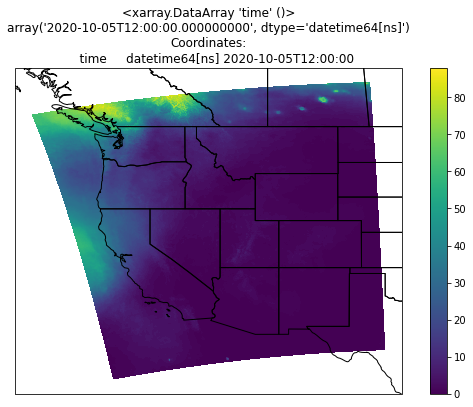

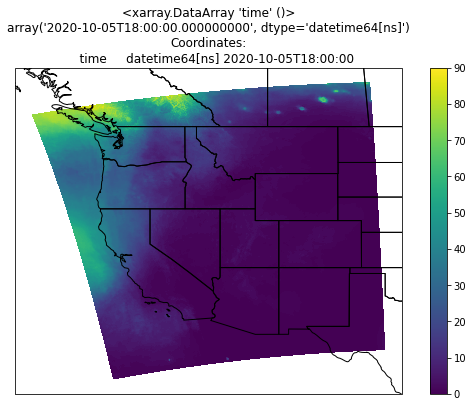

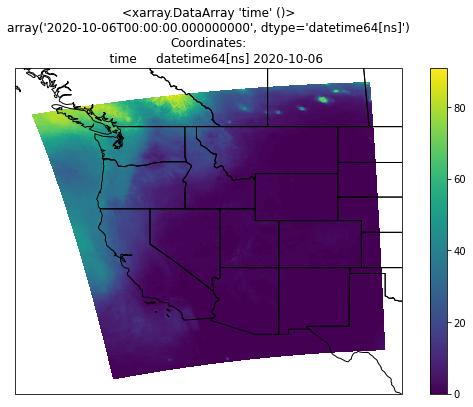

KeyboardInterrupt: 

In [52]:
for t in da.time:
        
    fig = plt.figure(figsize=(20/2, 12/2))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    da.sel(time=t).plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
    ax.set_title(t)
    plt.show()